In [1]:
import numpy as np
import random
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from google.colab import drive
#drive.mount('/content/drive')



In [2]:
# ________________________ALL FUNCTIONS AND CLASSES ___________________________


def make_network(m,n, noise_low, noise_high):
    O = nx.triangular_lattice_graph(m,n, periodic=False, with_positions=True, create_using=None)
    G = nx.convert_node_labels_to_integers(O)
    #nx.draw(G, with_labels=True)
    #plt.show()
    print(G)
    pos_dict = nx.get_node_attributes(G, "pos")

    num_nodes = len(G.nodes)
    num_springs = len(G.edges)
    
    x = torch.zeros(num_nodes, 2)
    values = list(pos_dict.values())
    for i in range(len(values)):
        x[i][0] = values[i][0]
        x[i][1] = values[i][1]
    
    # add noise to initial layout
    torch.random.manual_seed(8)
    base_x = x.detach().clone()
    noise = (noise_low - noise_high) * torch.rand(num_nodes, 2) + noise_high
    x = x+noise
    
    x.requires_grad = True
    
    indices = []
    for i, (node1,node2) in enumerate(G.edges):
        indices.append([node1,node2])

    return num_nodes, num_springs, x, indices, base_x

def make_incidence(indices, num_vertices):
    # this creates a dense matrix (incidence), but
    # sparse matrices or convolutions might be more appropriate
    # in certain cases
    num_springs = len(indices)
    incidence = torch.zeros(num_springs, num_vertices, dtype=torch.float32)
    for i, item in enumerate(indices):
        i1, i2 = item
        incidence[i, i1] = 1
        incidence[i, i2] = -1
    return incidence

def get_l0(num_springs, range_num, noise_scale = 0):
    l0 = torch.rand(num_springs) * range_num
    # add noise
    noise = (-noise_scale - noise_scale) * torch.rand(num_springs) + noise_scale
    buffer = torch.ones(num_springs) * noise_scale
    l0 = l0 + noise + buffer
    return l0

def get_k(num_springs, range_num):
    k = torch.rand(num_springs) * range_num
    #k = torch.ones(num_springs, dtype=torch.float32)
    #k = k + noise
    return k

def get_source_springs(nsprings, nsource_springs):
    s_springs = np.random.choice(nsprings, size=nsource_springs, replace=False, p=None)
    return s_springs

def get_target_springs(nsprings, ntarget_springs, s_springs):
    to_exclude = s_springs # cannot be the same springs as the source springs
    t_springs = random.sample(list(set([x for x in range(nsprings)]) - set(to_exclude)), k = ntarget_springs)
    return t_springs

def clamp_spring_length(spring_network, input_strain, spring, indices, x, l0):
 
    input_length = input_strain
    
    # get the corresponding nodes for the spring
    node1, node2 = indices[spring]
        
    x1 = x[node1][0]
    x2 = x[node2][0]
        
    y1 = x[node1][1]
    y2 = x[node2][1]
        
    delta_y = y2 - y1
    delta_x = x2 - x1
    
    current_length = spring_network.measure_spring_length(x, spring)
    ratio = input_length / current_length
    
    new_y = ratio * delta_y
    new_x = ratio * delta_x
    
    with torch.no_grad():
        x[node2][1] = x[node1][1] + new_y
        x[node2][0] = x[node1][0] + new_x
        
        l0[spring] = input_length
        k[spring] = 1e10
    return x

# main simulation loop
def run_to_equil(x, optimizer, network, iterations):
    energies = np.zeros(iterations)
    for i in range(iterations):
      optimizer.zero_grad()
      loss = network.energy(x).sum() # sum for total energy
      loss.backward()
      optimizer.step()
      energies[i] = loss
    return energies

class MSD(nn.Module):
  def __init__(self, indices, l0, k, num_vertices):
      super().__init__()
      self.indices = indices
      self.register_buffer("incidence", make_incidence(self.indices, num_vertices))
      self.register_buffer("l0", l0)
      self.register_buffer("k", k)
    
  def measure_spring_length(self, x, spring_index):
    d = self.incidence.mm(x)
    q = d.pow(2).sum(1)
    l = q.sqrt() 
    l = l[spring_index] # get the length of a particular spring by indexing
    return l
        
  def measure_spring_strain(self, x, spring_index):
    # strain = change in length / original length
    d = self.incidence.mm(x)
    q = d.pow(2).sum(1)
    l = q.sqrt()
    strain = (l / self.l0) - 1
    #dl = (l - self.l0)
    strain = strain[spring_index] # get the strain of a particular spring by indexing
    return strain
    
  def measure_length_change(self, x):
    d = self.incidence.mm(x)
    q = d.pow(2).sum(1)
    l = q.sqrt()
    dl = (l - self.l0)
    return dl
        
  def energy(self, x):
    d = self.incidence.float().mm(x) 
    q = d.pow(2).sum(1)
    l = q.sqrt()
    #l = (q + 1e-6).sqrt()
    dl = l - self.l0
    #e = 0.5 * (self.k * dl.pow(2)).sum()
    e = 0.5 * (self.k * dl.pow(2)) # without summing, returns vector of size = num_springs
    return e

  def energy_of_spring(self, x, spring_index):
    d = self.incidence.float().mm(x) 
    q = d.pow(2).sum(1)
    l = q.sqrt()
    #l = (q + 1e-6).sqrt()
    dl = l - self.l0
    #e = 0.5 * (self.k * dl.pow(2)).sum()
    e = 0.5 * (self.k * dl.pow(2)) # without summing, returns vector of size = num_springs
    return e[spring_index]
    
  def partial_e(self, x):
    # k * (r - l)
    d = self.incidence.float().mm(x) 
    q = d.pow(2).sum(1)
    l = q.sqrt()
    dl = l - self.l0
    partial_e = self.k * dl
    return partial_e

  def partial_e_spring(self, x, spring_index, new_l0, new_k):
    d = self.incidence.float().mm(x) 
    q = d.pow(2).sum(1)
    l = q.sqrt()
    dl = l - new_l0
    partial_e =new_k * dl
    return partial_e[spring_index]

  def partial_e_k(self, x):
    # k * (x - l)^2
    d = self.incidence.float().mm(x) 
    q = d.pow(2).sum(1)
    l = q.sqrt()
    dl = l - self.l0
    partial_e_k = self.k * dl.pow(2)
    return partial_e_k


In [3]:


# set seeds if you want the same network everytime
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create network
noise_low=-0.1
noise_high=0.1
num_nodes, num_springs, x, indices, base_x = make_network(3, 3, noise_low=noise_low, noise_high=noise_high)
num_springs = len(indices)

# copy initial conditions so that the network can be reinitialised each time
x_init = x.detach().clone()

# initialise learning degrees of freedom
# noise scale should not be greater than 1
l0 = get_l0(num_springs, 10, noise_scale=10)
#k = torch.ones(num_springs) * 25
k = get_k(num_springs, 50)

# select source springs
num_source_springs = 1
s_springs = get_source_springs(num_springs, num_source_springs)
print(s_springs) 


# select target springs 
num_targets = 1 # if we are only doing MNIST with 0s and 1s...
t_springs = get_target_springs(num_springs, num_targets, s_springs)
print(t_springs)

# instantiate network
spring_network = MSD(indices, l0, k, num_nodes)


Graph with 10 nodes and 18 edges
[1]
[13]


In [4]:
"""
______________________PC LEARNING RULE: ALLOSTERY_______________________________
"""

l0_init_t = l0[t_springs[0]].detach().clone()
k_init_t = k[t_springs[0]].detach().clone()

l0_init_s = l0[s_springs[0]].detach().clone()
k_init_s = k[s_springs[0]].detach().clone()

print(l0_init_t, k_init_t)

print(l0)


alpha = 5e-3
epochs = 150
run_time = 20000

mu, sigma = 0, 2.5
factor =  np.random.normal(mu, sigma, 1)[0]
#print(factor)
input_strain = factor + 5
sigma2 = 0.2*sigma
factor2 =  np.random.normal(mu, sigma2, 1)[0]
#print(factor2)
target = factor2 + 5

print('s and t')
print(input_strain)
print(target)

lengths_list = np.zeros(epochs)
target_l0s = np.zeros(epochs)
new_errors = np.zeros(epochs)
strains_overtime = np.zeros(epochs)
l0_based_errors = np.zeros(epochs)

errors = np.zeros(epochs)
energies_list = np.zeros(epochs)
partial_energies_list = np.zeros(epochs)
#l0[t_springs[0]] = 1

length = l0[t_springs[0]].detach().clone() * (target+1)
#length = l0[t_springs[0]] * (target+1)
print('clamped length|:', length)


for i in range(epochs):
  print('__________ITERATION NUMBER:________', i)
  #print('target value',length)
  spring_network.l0 = l0
  #length = l0[t_springs[0]] * (target+1)
  #print(length)
  #length = l0[t_springs[0]] * (target+1)
  #length = target
  print('l0 sum',l0.sum().item())

  target_l0s[i] = l0[t_springs[0]].item()

  # reset x
  with torch.no_grad():  
    x = x_init.detach().clone()
    x.requires_grad = True

  # reset source
  l0[s_springs[0]] = l0_init_s.detach().clone()
  k[s_springs[0]] = k_init_s.detach().clone()

  # clamp source inputs 
  x = clamp_spring_length(spring_network, input_strain, s_springs[0], indices, x, l0)

  # clamp target outputs
  #x = clamp_spring_length(spring_network, target, t_springs[0], indices, x, l0)
  x = clamp_spring_length(spring_network, length, t_springs[0], indices, x, l0)

  # instantiate the optimizer    
  optimizer = torch.optim.Adagrad([x], lr=1e-1)
  #print('before:', spring_network.energy(x).sum())
  # inference
  energies = run_to_equil(x, optimizer, spring_network, iterations=run_time)
  #print('e change:', energies[1], energies[-1])
  #print('after:', spring_network.energy(x).sum())

  # reset targets for partial energy calculation
  l0[t_springs[0]] = l0_init_t.detach().clone()
  #print('l0',l0[t_springs[0]])
  #print('l0init',l0_init_t )
  k[t_springs[0]] = k_init_t.detach().clone()
  spring_network.k = k
  spring_network.l0 = l0
    
  # need to make sure that the partial energy of the source and target remain at zero
  # this is because they are clamped, so there was no dL
  partial_energy = spring_network.partial_e(x)
  partial_energy[s_springs[0]] = 0
  #partial_energy[t_springs[0]] = 0

  #print('partial',partial_energy.sum().item())
  partial_energies_list[i] = partial_energy.sum().item()

  #lengths_list[i] = spring_network.measure_spring_length(x, t_springs).item()
  energies_list[i] = spring_network.energy(x).sum().item()
  print('l0 before:', l0[t_springs[0]])
  # weight update
  with torch.no_grad():
    new_l0 = l0 + (alpha * partial_energy)
    new_l0[new_l0<0] = 1e-5
    #new_l0 = l0 - (alpha * partial_energy)
    l0 = new_l0

  spring_network.l0 = new_l0
  print('l0 after:', l0[t_springs[0]])

  l0_init_t = l0[t_springs[0]].detach().clone()
  print('l0_init_t',l0_init_t)



  print("_____get error____")

  # reset x
  with torch.no_grad():
    x = x_init.detach().clone()
    x.requires_grad = True

  # reset source
  l0[s_springs[0]] = l0_init_s.detach().clone()
  k[s_springs[0]] = k_init_s.detach().clone()

   
  # clamp source inputs 
  x = clamp_spring_length(spring_network, input_strain, s_springs[0], indices, x, l0)

  # instantiate the optimizer    
  optimizer = torch.optim.Adagrad([x], lr=1e-1)
  #print('before:', spring_network.energy(x).sum())
  # inference
  energies = run_to_equil(x, optimizer, spring_network, iterations=run_time)
  #print('after:', spring_network.energy(x).sum())
  # measure free state target
  len = spring_network.measure_spring_length(x, t_springs[0])
  lengths_list[i] = len.item()
  print('l0:', l0[t_springs[0]])
  print('length',len.item())
  strain = spring_network.measure_spring_strain(x, t_springs[0])
  print('strain',strain.item())
  strains_overtime[i] = strain.item()
  #error = strain - target
  error = 0.5 * torch.pow((target - strain), 2)
  if (strain > target):
        error = error * -1
  print('ERROR:',error.item())
  errors[i] = error.item()
  new_error = length - len
  #new_error = target - len
  print(new_error.item())
  new_errors[i] = new_error.item()
  l0_based_errors[i] = length - l0[t_springs[0]].item()
  
  #print('after learning l', spring_network.measure_spring_length(x, t_springs[0]))

  print("_____")



tensor(5.5702) tensor(10.6336)
tensor([21.4511, 16.9002,  4.1292, 10.1420, 15.5955, 17.0711,  9.0577,  5.5966,
        17.0765,  9.0419, 17.5676,  9.2293,  9.2100,  5.5702,  7.6587, 10.0846,
        16.1991, 17.9814])
s and t
8.413667948781054
4.951152139140287
clamped length|: tensor(33.1493)
__________ITERATION NUMBER:________ 0
l0 sum 219.56280517578125
l0 before: tensor(5.5702)
l0 after: tensor(7.0365)
l0_init_t tensor(7.0365)
_____get error____
l0: tensor(7.0365)
length 9.875683784484863
strain 0.40348386764526367
ERROR: 10.340643882751465
23.273597717285156
_____
__________ITERATION NUMBER:________ 1
l0 sum 213.1036376953125
l0 before: tensor(7.0365)
l0 after: tensor(8.4249)
l0_init_t tensor(8.4249)
_____get error____
l0: tensor(8.4249)
length 10.762874603271484
strain 0.27750635147094727
ERROR: 10.921483039855957
22.38640594482422
_____
__________ITERATION NUMBER:________ 2
l0 sum 214.8896942138672
l0 before: tensor(8.4249)
l0 after: tensor(9.7395)
l0_init_t tensor(9.7395)
_____

In [5]:
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/errors/errors_{seed}_t_learn", errors)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/lengths_list/lengths_list_{seed}_t_learn", lengths_list)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/new_errors/new_errors_{seed}_t_learn", new_errors)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/strains/strains_{seed}_t_learn", strains_overtime)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/trained_l0s/final_l0s_{seed}_repeated", spring_network.l0)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/target_spring_l0/TL0_{seed}_t_learn", target_l0s)
#np.save(f"drive/My Drive/project_data/pc_allostery_t_learn/target_spring_l0/l0_based_errors_{seed}_t_learn", l0_based_errors)

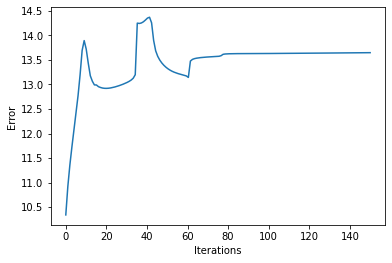

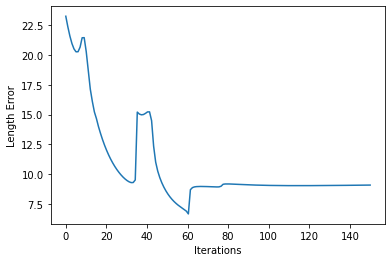

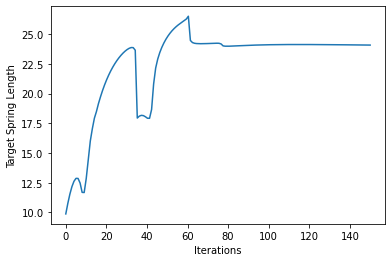

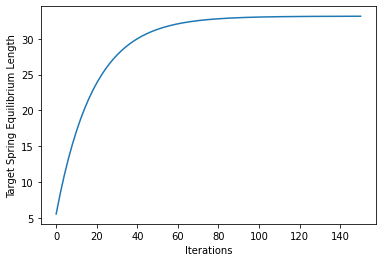

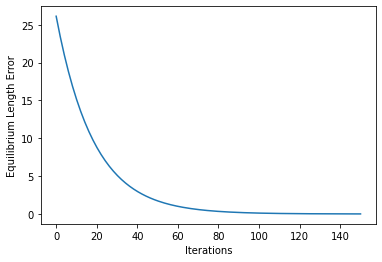

In [6]:
plt.plot(np.linspace(0, epochs,epochs), errors)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

plt.plot(np.linspace(0, epochs,epochs), new_errors)
plt.xlabel('Iterations')
plt.ylabel('Length Error')
plt.show()

plt.plot(np.linspace(0, epochs,epochs), lengths_list)
plt.xlabel('Iterations')
plt.ylabel('Target Spring Length')
plt.show()

plt.plot(np.linspace(0, epochs,epochs), target_l0s)
plt.xlabel('Iterations')
plt.ylabel('Target Spring Equilibrium Length')
plt.show()


plt.plot(np.linspace(0, epochs,epochs), l0_based_errors)
plt.xlabel('Iterations')
plt.ylabel('Equilibrium Length Error')
plt.show()






In [7]:
spring_network

MSD()

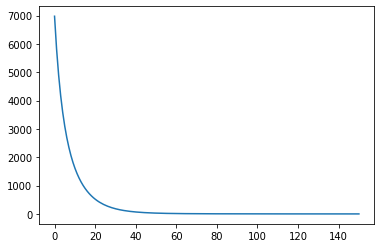

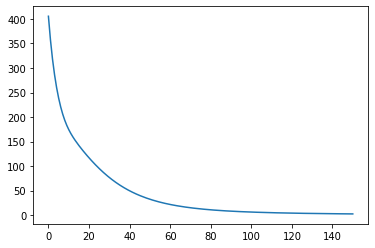

In [8]:

plt.plot(np.linspace(0,epochs,epochs), energies_list)
plt.show()

plt.plot(np.linspace(0,epochs,epochs), partial_energies_list)
plt.show()


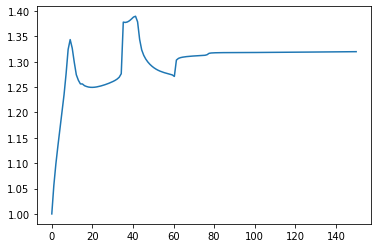

In [9]:
errors = errors / errors[0]
plt.plot(np.linspace(0, errors.shape[0], errors.shape[0]), errors)
plt.show()

In [10]:
#___________________________________after ____________________________________

inputs_list = np.linspace(1, 10, 10)

strains_list = []
lens_list = []


for inp in list(inputs_list):

  with torch.no_grad():
    x = x_init.detach().clone()
    x.requires_grad = True

  # reset source
  l0[s_springs[0]] = l0_init_s.detach().clone()
  k[s_springs[0]] = k_init_s.detach().clone()

  # reset targets
  l0[t_springs[0]] = l0_init_t.detach().clone()
  k[t_springs[0]] = k_init_t.detach().clone()

  # clamp source inputs 
  x = clamp_spring_length(spring_network, inp, s_springs[0], indices, x, l0)

  # instantiate the optimizer    
  optimizer = torch.optim.Adagrad([x], lr=1e-1)

  # inference
  energies = run_to_equil(x, optimizer, spring_network, iterations=run_time)

  # measure free state target
  strains_list.append(spring_network.measure_spring_strain(x, t_springs[0]).item())
  lens_list.append(spring_network.measure_spring_length(x, t_springs[0]).item())

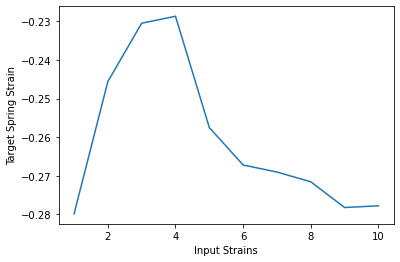

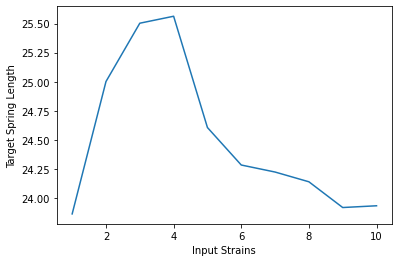

In [11]:
plt.plot(inputs_list, strains_list)
#plt.plot(inputs_list, np.full(10, target))
plt.xlabel("Input Strains")
plt.ylabel("Target Spring Strain")
plt.show()

plt.plot(inputs_list, lens_list)
plt.xlabel("Input Strains")
plt.ylabel("Target Spring Length")
plt.show()
